# Predict Covid-19 in X-ray images

## Part 2: Train the model

### Step 1: import everything

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

### Step 2: define some variables

In [2]:
# Define some paths
dataset = './dataset'
plot_path = './plot.png'
model_save_path = 'covid19.model'

# initialize the initial learning rate, number of epochs to train for, and batch size
INIT_LR = 1e-3
EPOCHS = 5
BS = 8

In [3]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("Loading images...")
imagePaths = list(paths.list_images(dataset))
data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]

    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))

    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)

print("Loaded {} images!\n".format(len(imagePaths)))  

Loading images...
Loaded 112 images!



In [4]:
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 255]
data = np.array(data) / 255.0
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)

# initialize the training data augmentation object
trainAug = ImageDataGenerator(
    rotation_range=15,
    fill_mode="nearest")

In [5]:
# load the VGG16 network, ensuring the head FC layer sets are left off
baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

# compile our model
print("Compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

model.compile(
    loss="binary_crossentropy", 
    optimizer=opt,
	metrics=["accuracy"]
)

Compiling model...


In [6]:
# train the head of the network
print("Ttraining head...")
H = model.fit(
    trainAug.flow(trainX, trainY, batch_size = BS),
    steps_per_epoch = len(trainX) // BS,
    validation_data = (testX, testY),
    validation_steps = len(testX) // BS,
    epochs = EPOCHS
)

Ttraining head...
  ...
    to  
  ['...']
Train for 11 steps, validate on 23 samples
Epoch 1/5
11/11 [==============================] - 28s 3s/step - loss: 0.7135 - accuracy: 0.4444 - val_loss: 0.4520 - val_accuracy: 0.5625
Epoch 2/5
11/11 [==============================] - 31s 3s/step - loss: 0.6962 - accuracy: 0.5062 - val_loss: 0.4366 - val_accuracy: 0.6875
Epoch 3/5
11/11 [==============================] - 28s 3s/step - loss: 0.6821 - accuracy: 0.4938 - val_loss: 0.4238 - val_accuracy: 0.6250
Epoch 4/5
11/11 [==============================] - 26s 2s/step - loss: 0.5503 - accuracy: 0.7531 - val_loss: 0.4207 - val_accuracy: 0.7500
Epoch 5/5
11/11 [==============================] - 26s 2s/step - loss: 0.5544 - accuracy: 0.7407 - val_loss: 0.3953 - val_accuracy: 0.7500


Evaluating network...
              precision    recall  f1-score   support

       covid       0.70      0.64      0.67        11
      normal       0.69      0.75      0.72        12

    accuracy                           0.70        23
   macro avg       0.70      0.69      0.69        23
weighted avg       0.70      0.70      0.69        23

[[7 4]
 [3 9]]
acc: 0.6957
sensitivity: 0.6364
specificity: 0.7500


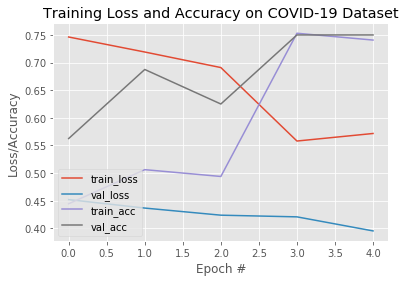

In [7]:
# make predictions on the testing set
print("Evaluating network...")
predictions = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predictions = np.argmax(predictions, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predictions,
	target_names=lb.classes_))

# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predictions)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(plot_path)

In [8]:
# serialize the model to disk
print("Saving COVID-19 detector model...")
model.save(model_save_path, save_format="h5")

Saving COVID-19 detector model...
